
# Random Forest Regressor con datos agrícolas — **versión explicada**

En este cuaderno entrenamos un **Random Forest Regressor** para predecir **`Producción_Ton`** desde tu archivo `1. datos_agricolas.xlsx` (hoja **Inicio**).  
Incluye: EDA ligera, preprocesamiento con `ColumnTransformer`, entrenamiento, métricas, gráfico **Predicho vs Real** e **importancia de variables**.



## Paso 0 · Requisitos
- Archivo disponible en la misma carpeta del notebook (ajusta la ruta si es necesario).
- Librerías: `pandas`, `scikit-learn`, `matplotlib`, `openpyxl` para leer Excel.
- Objetivo: predecir `Producción_Ton` **sin** usar `Ingresos` o `Utilidad` (evitamos fuga de información).



## Paso 1 · Importar librerías


In [1]:

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt
from pathlib import Path



## Paso 2 · Cargar datos


In [2]:

# 🔁 Ajusta la ruta si no estás ejecutando este notebook en ChatGPT
file_path = "1. datos_agricolas.xlsx"  # Ejemplo local: "1. datos_agricolas.xlsx"
df = pd.read_excel(file_path, sheet_name="Inicio")
df.head()


,Año,Mes,Región,Cultivo,Superficie_Ha,Producción_Ton,Precio_Ton,Costos_Insumos,Ingresos,Utilidad
0,2023,7,Sur,Manzana,34,4583,377.65,5267,1730769.95,1725502.95
1,2024,5,Centro,Tomate,253,3501,106.45,6988,372681.45,365693.45
2,2023,3,Sur,Soja,430,716,249.06,9680,178326.96,168646.96
3,2023,3,Sur,Soja,37,3074,240.68,2485,739850.32,737365.32
4,2023,4,Norte,Maíz,462,763,317.39,15713,242168.57,226455.57



## Paso 3 · Exploración breve (EDA)
- Revisa tipos, nulos y estadísticas básicas.


In [3]:

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Año             1800 non-null   int64  
 1   Mes             1800 non-null   int64  
 2   Región          1800 non-null   object 
 3   Cultivo         1800 non-null   object 
 4   Superficie_Ha   1800 non-null   int64  
 5   Producción_Ton  1800 non-null   int64  
 6   Precio_Ton      1800 non-null   float64
 7   Costos_Insumos  1800 non-null   int64  
 8   Ingresos        1800 non-null   float64
 9   Utilidad        1800 non-null   float64
dtypes: float64(3), int64(5), object(2)
memory usage: 140.8+ KB


In [4]:

df.describe(include="all").T


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Año,1800.0,NaN,NaN,NaN,2023.493889,0.500102,2023.0,2023.0,2023.0,2024.0,2024.0
Mes,1800.0,NaN,NaN,NaN,6.471111,3.450797,1.0,3.75,6.0,9.0,12.0
Región,1800,3,Norte,638,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cultivo,1800,7,Manzana,274,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Superficie_Ha,1800.0,NaN,NaN,NaN,246.046111,143.402285,5.0,119.75,241.0,372.0,499.0
Producción_Ton,1800.0,NaN,NaN,NaN,2500.136111,1440.965374,22.0,1226.0,2478.0,3782.5,4999.0
Precio_Ton,1800.0,NaN,NaN,NaN,294.1675,114.812603,100.1,194.3575,290.56,391.5875,499.68
Costos_Insumos,1800.0,NaN,NaN,NaN,10463.516667,5543.629521,1015.0,5637.5,10454.5,15283.0,19996.0
Ingresos,1800.0,NaN,NaN,NaN,730882.352328,532210.614766,3903.76,299830.0575,619911.25,1054964.955,2449579.37
Utilidad,1800.0,NaN,NaN,NaN,720418.835661,532189.137805,-6486.34,288587.88,609028.41,1044912.85,2430133.37



## Paso 4 · Selección de variables y división Train/Test
- **Target (y):** `Producción_Ton`  
- **Features (X):** `Año`, `Mes`, `Región`, `Cultivo`, `Superficie_Ha`, `Precio_Ton`, `Costos_Insumos`  
- Split 80/20 con semilla fija para reproducibilidad.


In [5]:

target_col = "Producción_Ton"
feature_cols = ["Año", "Mes", "Región", "Cultivo", "Superficie_Ha", "Precio_Ton", "Costos_Insumos"]

X = df[feature_cols].copy()
y = df[target_col].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

len(X_train), len(X_test)


(1440, 360)


## Paso 5 · Preprocesamiento con `ColumnTransformer`
- Numéricas: imputación por mediana + escalado estándar
- Categóricas: imputación por moda + `OneHotEncoder` (ignora categorías desconocidas)


In [6]:

numeric_features = ["Año", "Mes", "Superficie_Ha", "Precio_Ton", "Costos_Insumos"]
categorical_features = ["Región", "Cultivo"]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)



## Paso 6 · Entrenamiento de **Random Forest Regressor**
- Bosque de 300 árboles, semilla fija y uso de todos los núcleos disponibles.


In [7]:

rf_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1))
])

rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)



## Paso 7 · Evaluación del modelo
- Métricas: **MAE**, **RMSE** (= √MSE), **R²**.


In [8]:

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.3f}")


MAE: 1289.99
RMSE: 1518.42
R2: -0.113



## Paso 8 · Gráfico Predicho vs Real
- Puntos cercanos a la diagonal ⇒ mejor ajuste.


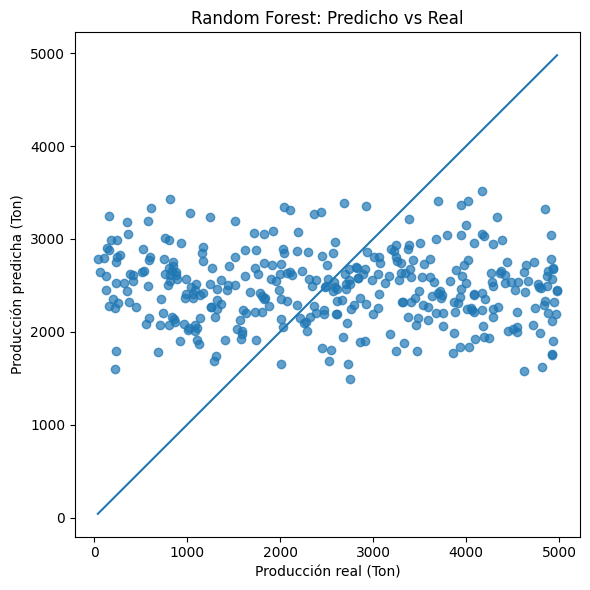

In [9]:

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val])
plt.xlabel("Producción real (Ton)")
plt.ylabel("Producción predicha (Ton)")
plt.title("Random Forest: Predicho vs Real")
plt.tight_layout()
plt.show()



## Paso 9 · Importancia de variables
- Mide la contribución de cada característica a las predicciones del bosque.


In [10]:

# Recuperar nombres tras el one-hot
ohe = rf_model.named_steps["preprocessor"].named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = list(ohe.get_feature_names_out(categorical_features))
num_feature_names = numeric_features
all_features = num_feature_names + cat_feature_names

rf = rf_model.named_steps["model"]
importances = rf.feature_importances_

imp_df = pd.DataFrame({"feature": all_features, "importance": importances})\
          .sort_values("importance", ascending=False)

imp_df.head(15)


,feature,importance
3,Precio_Ton,0.247284
4,Costos_Insumos,0.231664
2,Superficie_Ha,0.213148
1,Mes,0.109975
0,Año,0.024162
14,Cultivo_Uva,0.020201
10,Cultivo_Papa,0.019453
8,Cultivo_Manzana,0.018362
6,Región_Norte,0.018060
9,Cultivo_Maíz,0.017266


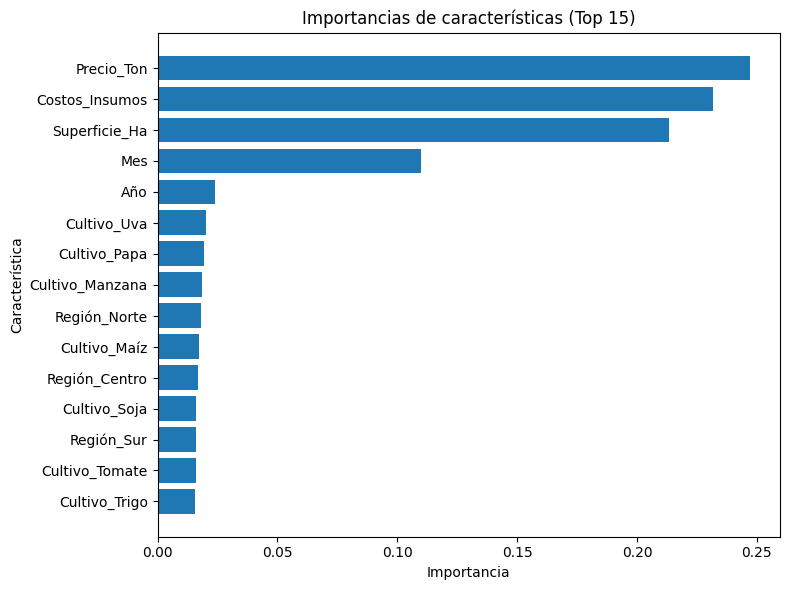

In [11]:

top = imp_df.head(15)
plt.figure(figsize=(8,6))
plt.barh(top["feature"][::-1], top["importance"][::-1])
plt.xlabel("Importancia")
plt.ylabel("Característica")
plt.title("Importancias de características (Top 15)")
plt.tight_layout()
plt.show()



## Paso 10 · Conclusiones y siguientes pasos
- Random Forest captura **no linealidades** e **interacciones** mejor que una regresión lineal.
- Revisa el ranking de importancias para orientar decisiones (p. ej., superficie, cultivo, región).
- Próximos pasos: **validación cruzada**, **búsqueda de hiperparámetros** (`RandomizedSearchCV`/`GridSearchCV`), ingeniería de variables (estacionalidad, interacciones), y evaluación con un conjunto de validación temporal si la serie tiene componente estacional.
